In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred

$y_t = a_{S_t} + x_t' \beta_{S_t} + \phi_{1, S_t}
        (y_{t-1} - a_{S_{t-1}} - x_{t-1}' \beta_{S_{t-1}}) + \dots +
        \phi_{p, S_t} (y_{t-p} - a_{S_{t-p}} - x_{t-p}' \beta_{S_{t-p}}) +
        \varepsilon_t \\
        \varepsilon_t \sim N(0, \sigma_{S_t}^2)$

In [2]:
# import fredkey
fred = Fred(api_key='d59606a150e09c54fd5158bac863da0d') # Jeg skuler min nøkkel her. Skaff din egen.

In [3]:
# requesting data used in the Chauvet paper
series = {
   # name : series id
    'MTS' : 'CMRMTSPL', # manufacturing and trade sales
    'PILTP' : 'W875RX1', # total personal income less transfer payments
    'ENAP' : 'PAYEMS', # employees on nonagricultural payrolls
    'IPMAN' : 'IPMAN' # industrial production
}

def gen_dataset(series: dict):
    lst = []
    for i in series.keys():
        data = fred.get_series(series[i])
        data = data.rename(i)
        lst.append(data)
    
    return pd.concat(lst, axis=1)

df = gen_dataset(series)
df = df.dropna()
df.head()

,MTS,PILTP,ENAP,IPMAN
1972-01-01,436061.565,4208.2,72441.0,35.9488
1972-02-01,431354.862,4231.9,72648.0,36.2194
1972-03-01,439346.765,4259.5,72944.0,36.4664
1972-04-01,442331.562,4273.3,73162.0,36.8786
1972-05-01,445055.610,4291.2,73469.0,36.9454


In [4]:
recession = fred.get_series('USRECDM')
recession.head()

1854-12-01    1.0
1854-12-02    1.0
1854-12-03    1.0
1854-12-04    1.0
1854-12-05    1.0
dtype: float64

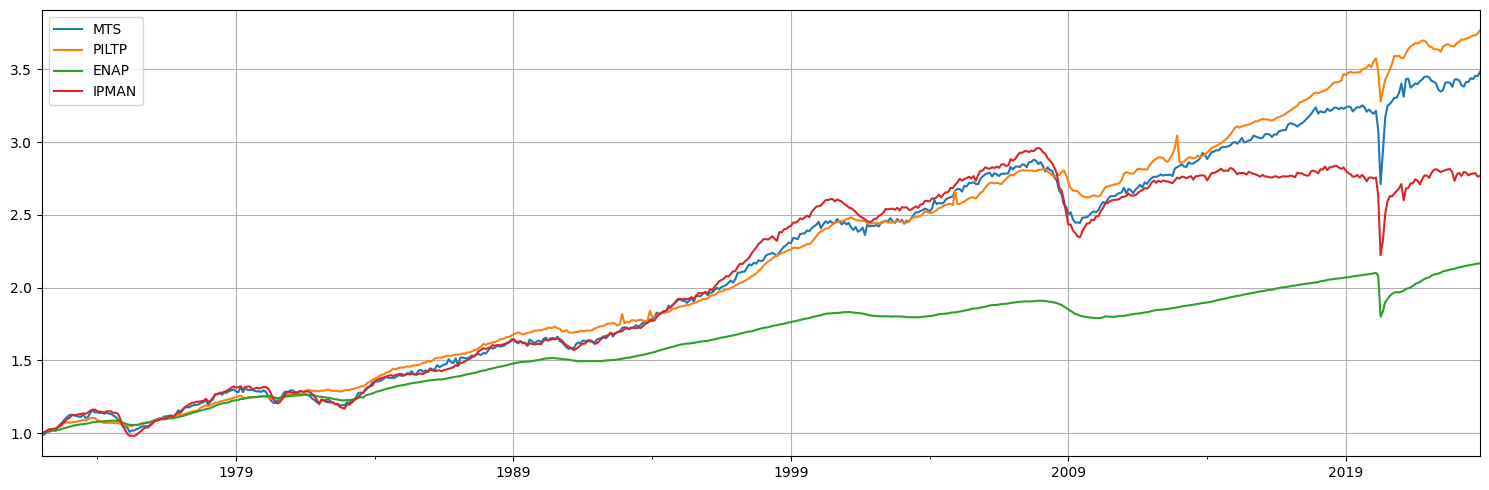

In [5]:
fig, ax = plt.subplots(figsize=(15, 5))

(df / df.iloc[0]).plot(ax=ax)

recession_period = recession.loc[recession.index.isin(df.index)]
# ax.fill_between(df.index, df.min().min(), df.max().max(), where=recession_period.values, color="k", alpha=0.3)

plt.grid()
plt.tight_layout()
plt.show()


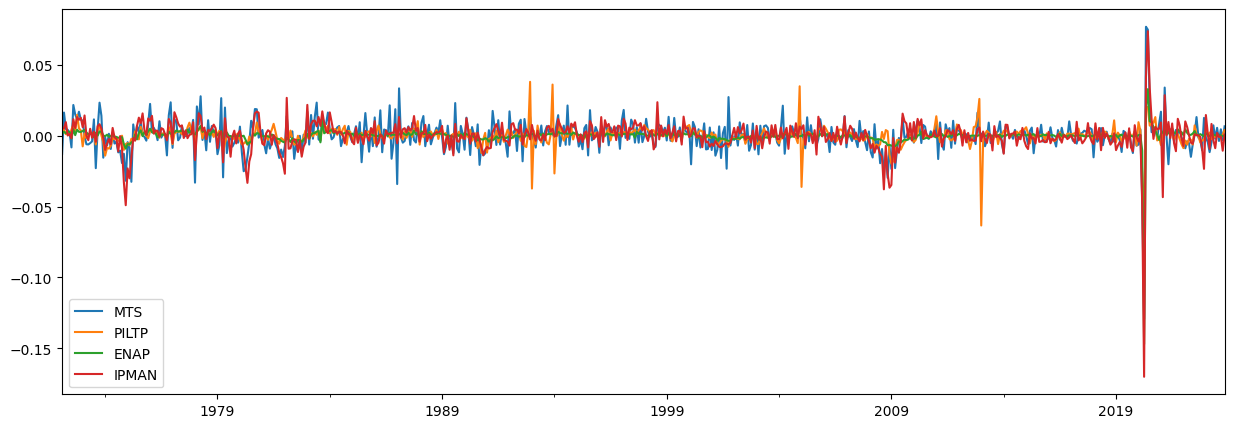

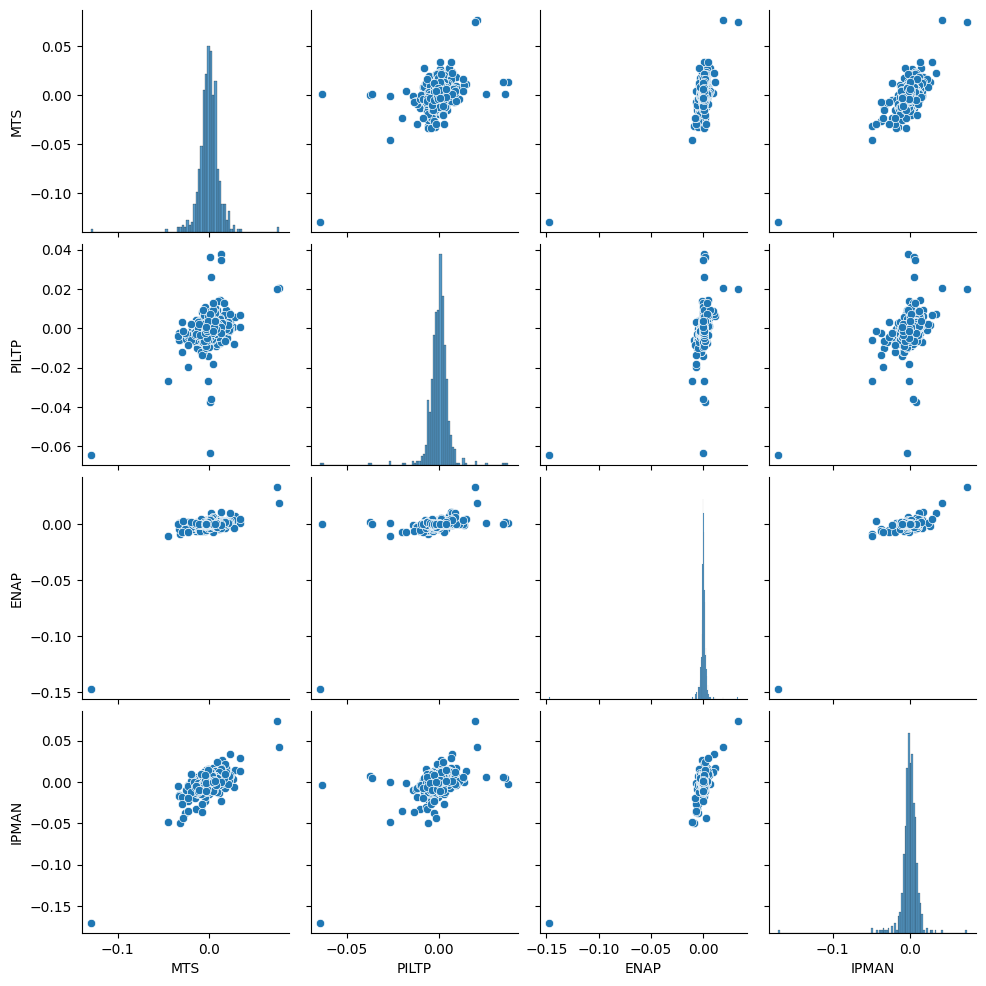

In [6]:
df2 = df.apply(lambda x: np.log(x))
df2 = df2.diff()
df2 = df2 - df2.mean()
df2 = df2.dropna()
df2.plot(figsize=(15,5))
plt.show()

import seaborn as sns
sns.pairplot(df2)
plt.show()

# Factor model without switching

In [51]:
from statsmodels.tsa.statespace.dynamic_factor import DynamicFactor
dfm = DynamicFactor(
    df2, 
                                      k_factors=1, 
                                      factor_order=2, 
                                      error_order=2,
                                      error_var=False,
                                      enforce_stationarity=False
                                      )

res = dfm.fit(maxiter=500)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.90460D+00    |proj g|=  5.62569D+01


 This problem is unconstrained.



At iterate    5    f= -1.14476D+01    |proj g|=  1.40131D+01

At iterate   10    f= -1.14535D+01    |proj g|=  2.64104D+00

At iterate   15    f= -1.15875D+01    |proj g|=  5.47417D+01

At iterate   20    f= -1.16458D+01    |proj g|=  3.90309D+00

At iterate   25    f= -1.17656D+01    |proj g|=  3.71497D+01

At iterate   30    f= -1.21109D+01    |proj g|=  7.55890D+00

At iterate   35    f= -1.25966D+01    |proj g|=  2.91302D+01

At iterate   40    f= -1.33349D+01    |proj g|=  5.55536D+01

At iterate   45    f= -1.40047D+01    |proj g|=  6.08097D+01

At iterate   50    f= -1.42030D+01    |proj g|=  2.26648D+01

At iterate   55    f= -1.42087D+01    |proj g|=  3.15477D-01

At iterate   60    f= -1.42090D+01    |proj g|=  4.25266D+00

At iterate   65    f= -1.42364D+01    |proj g|=  2.57324D+01

At iterate   70    f= -1.43183D+01    |proj g|=  1.05492D+00

At iterate   75    f= -1.43183D+01    |proj g|=  1.73894D-01

           * * *

Tit   = total number of iterations
Tnf   = total nu

In [52]:
print(res.summary())

                                   Statespace Model Results                                  
Dep. Variable:     ['MTS', 'PILTP', 'ENAP', 'IPMAN']   No. Observations:                  622
Model:             DynamicFactor(factors=1, order=2)   Log Likelihood                8905.983
                                      + AR(2) errors   AIC                         -17775.966
Date:                               Wed, 07 Feb 2024   BIC                         -17696.173
Time:                                       15:11:34   HQIC                        -17744.954
Sample:                                   02-01-1972                                         
                                        - 11-01-2023                                         
Covariance Type:                                 opg                                         
Ljung-Box (L1) (Q):     0.87, 0.02, 0.45, 0.18   Jarque-Bera (JB):   29821.23, 14702.32, 1403884.47, 368.15
Prob(Q):                0.35, 0.89, 0.50, 0.67

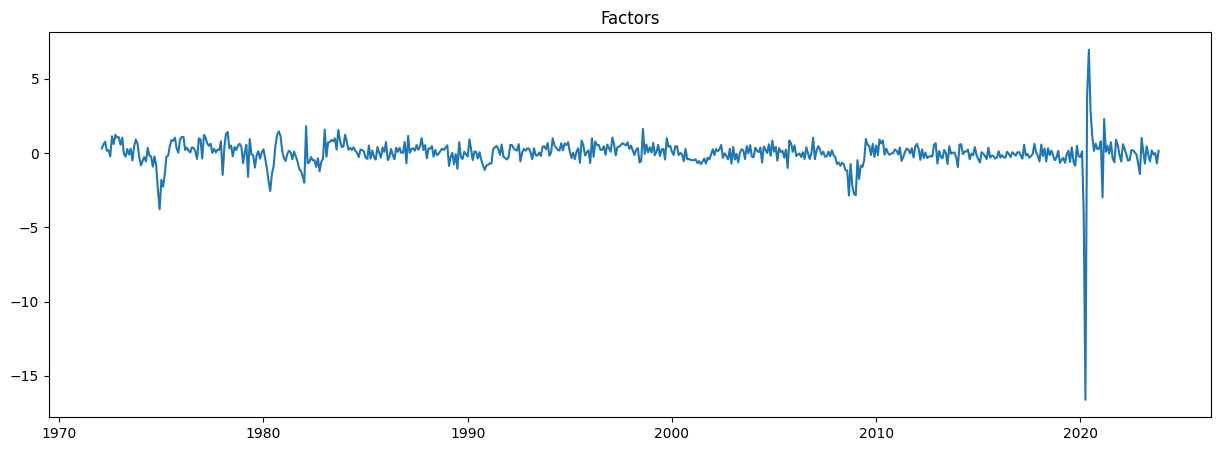

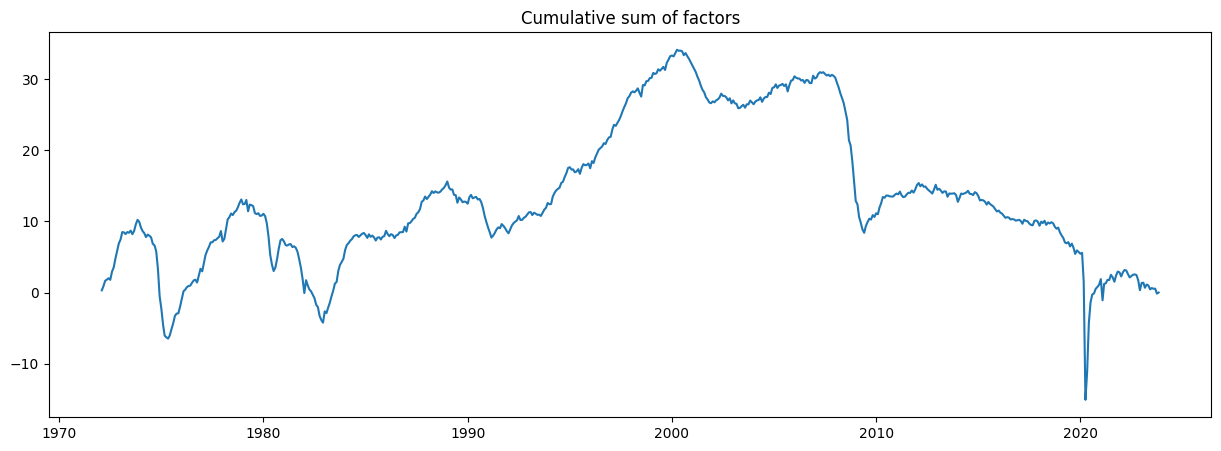

In [53]:
plt.figure(figsize=(15,5))
for i in range(res.factors['filtered'].shape[0]):
    plt.plot(df2.index, res.factors['filtered'][i])
plt.title('Factors')
plt.show()

plt.figure(figsize=(15,5))
for i in range(res.factors['filtered'].shape[0]):
    plt.plot(df2.index, np.cumsum(res.factors['filtered'][i]))
plt.title('Cumulative sum of factors')
plt.show()

## More variables

In [21]:
ext_series = {
   # name : series id
    'MTS' : 'CMRMTSPL', # manufacturing and trade sales
    'PILTP' : 'W875RX1', # total personal income less transfer payments
    'ENAP' : 'PAYEMS', # employees on nonagricultural payrolls
    'IPMAN' : 'IPMAN', # industrial production
    'UNRATE' : 'UNRATE', # Unemployment Rate 
    # 'LOANS' : 'LOANS', # Loans and Leases in Bank Credit, All Commercial Banks
    '1y_yield' : 'DGS1', # Market Yield on U.S. Treasury Securities at 1-Year Constant
    '10y_yield' : 'DGS10', # Market Yield on U.S. Treasury Securities at 10-Year Constant
    'PCE' : 'PCE', # Personal Consumption Expenditures
    # 'stocks' : 'M1109BUSM293NNBR', # Share Prices: All Shares/Broad: Total for United
    'ind_loans' : 'BUSLOANS', # Commercial and Industrial Loans, All Commercial Banks
}

df3 = gen_dataset(ext_series)
df3 = df3.dropna()
df3

,MTS,PILTP,ENAP,IPMAN,UNRATE,1y_yield,10y_yield,PCE,ind_loans
1972-02-01,431354.862,4231.9,72648.0,36.2194,5.7,4.44,6.09,736.2,118.8982
1972-03-01,439346.765,4259.5,72944.0,36.4664,5.8,4.28,6.04,749.2,119.6910
1972-05-01,445055.610,4291.2,73469.0,36.9454,5.7,4.57,6.14,758.0,122.6920
1972-06-01,446997.410,4304.2,73758.0,37.0530,5.7,4.72,6.07,761.6,123.7672
1972-08-01,454870.354,4375.5,74141.0,37.5429,5.6,4.83,6.14,776.3,126.0083
...,...,...,...,...,...,...,...,...,...
2023-05-01,1489005.000,15622.4,155787.0,100.3586,3.7,4.86,3.59,18407.8,2769.2335
2023-06-01,1488903.000,15638.0,156027.0,99.6427,3.6,5.11,3.61,18485.4,2764.0889
2023-08-01,1497717.000,15707.7,156421.0,100.0939,3.8,5.38,4.05,18651.6,2764.0963
2023-09-01,1507530.000,15719.1,156667.0,100.2040,3.8,5.36,4.18,18791.5,2765.4169


<Axes: >

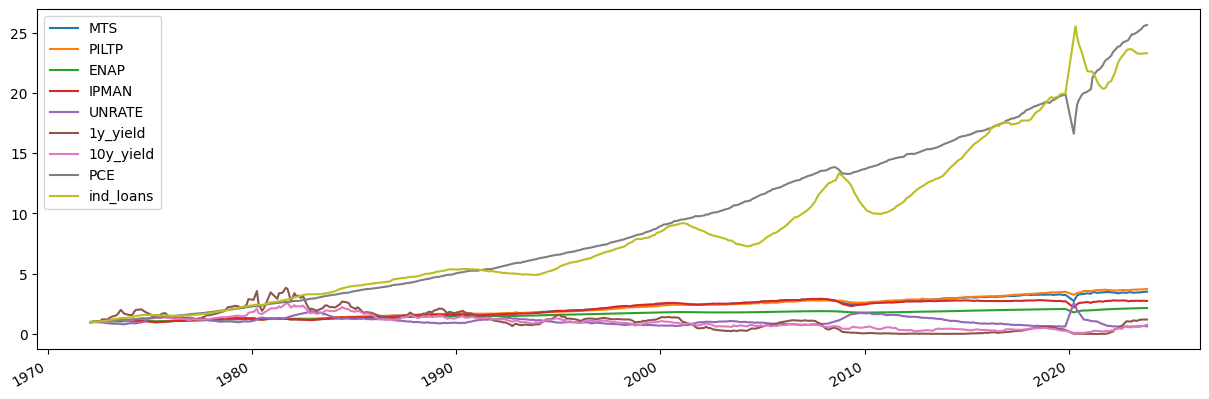

In [22]:
(df3/df3.iloc[0]).plot(figsize=(15,5))

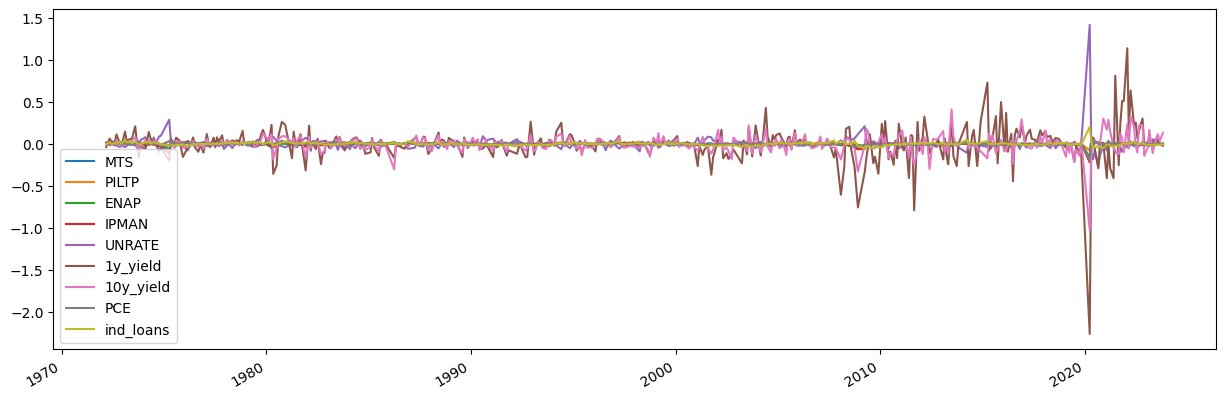

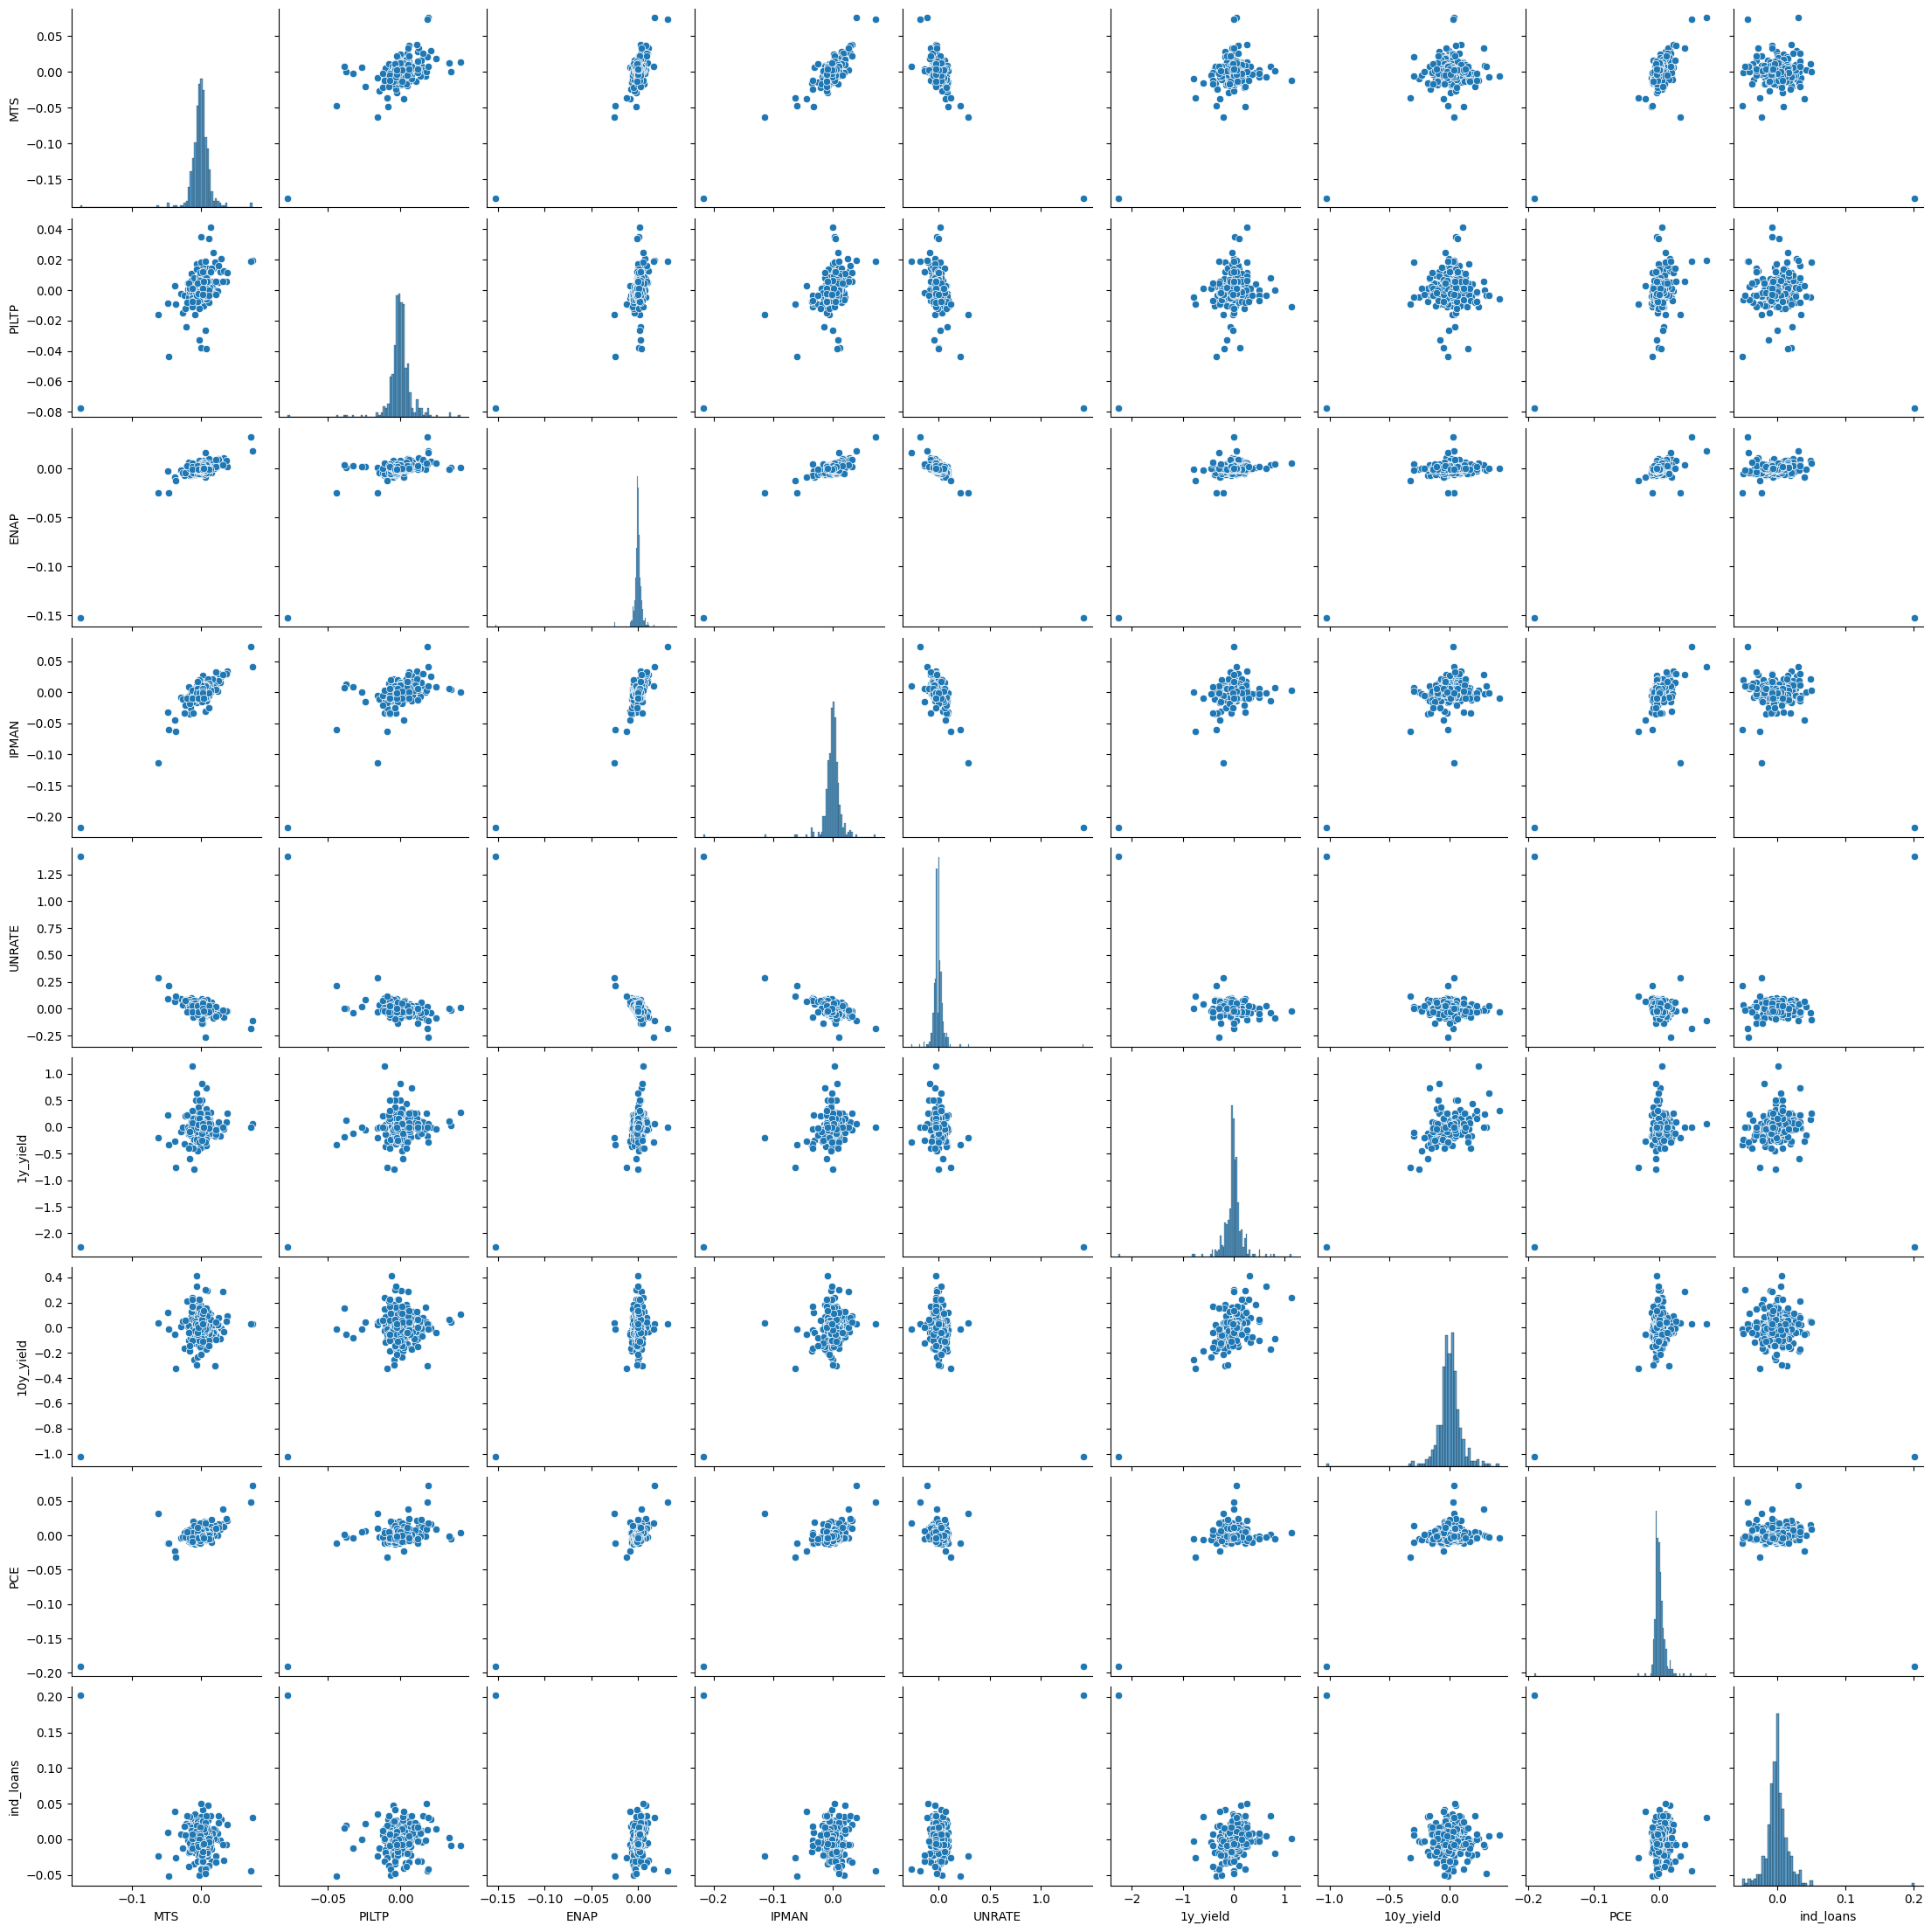

In [23]:
df4 = df3.apply(lambda x: np.log(x))
df4 = df4.diff()
df4 = df4 - df4.mean()
df4 = df4.dropna()
df4.plot(figsize=(15,5))
plt.show()

import seaborn as sns
sns.pairplot(df4)
plt.show()

In [43]:
df4.corr()

,MTS,PILTP,ENAP,IPMAN,UNRATE,1y_yield,10y_yield,PCE,ind_loans
MTS,1.000000,0.572781,0.750102,0.835500,-0.714722,0.402381,0.313161,0.710866,-0.329868
PILTP,0.572781,1.000000,0.587256,0.566310,-0.566655,0.327121,0.241699,0.472008,-0.179927
ENAP,0.750102,0.587256,1.000000,0.831049,-0.926115,0.580302,0.494281,0.815084,-0.422394
IPMAN,0.835500,0.566310,0.831049,1.000000,-0.781610,0.495676,0.413508,0.666610,-0.345660
UNRATE,-0.714722,-0.566655,-0.926115,-0.781610,1.000000,-0.565609,-0.472501,-0.722012,0.463363
1y_yield,0.402381,0.327121,0.580302,0.495676,-0.565609,1.000000,0.635875,0.436615,-0.158674
10y_yield,0.313161,0.241699,0.494281,0.413508,-0.472501,0.635875,1.000000,0.462240,-0.276472
PCE,0.710866,0.472008,0.815084,0.666610,-0.722012,0.436615,0.462240,1.000000,-0.359743
ind_loans,-0.329868,-0.179927,-0.422394,-0.345660,0.463363,-0.158674,-0.276472,-0.359743,1.000000


In [44]:
dfm2 = DynamicFactor(
    df4, 
                                      k_factors=1, 
                                      factor_order=2, 
                                      error_order=2,
                                      error_var=False,
                                      enforce_stationarity=False
                                      )

res2 = dfm2.fit(maxiter=500)

/Users/williamsoma/miniconda3/envs/jobb/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           38     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.92130D+01    |proj g|=  7.04517D+01


 This problem is unconstrained.



At iterate    5    f= -2.03718D+01    |proj g|=  1.47988D+01

At iterate   10    f= -2.04674D+01    |proj g|=  4.09838D+01

At iterate   15    f= -2.07208D+01    |proj g|=  1.29759D+01

At iterate   20    f= -2.07260D+01    |proj g|=  3.54089D+00

At iterate   25    f= -2.07483D+01    |proj g|=  3.13709D+00

At iterate   30    f= -2.07610D+01    |proj g|=  1.72114D+01

At iterate   35    f= -2.07758D+01    |proj g|=  1.02325D+00

At iterate   40    f= -2.07811D+01    |proj g|=  5.19495D+00

At iterate   45    f= -2.07838D+01    |proj g|=  3.58197D+00

At iterate   50    f= -2.07913D+01    |proj g|=  3.73927D+00

At iterate   55    f= -2.07997D+01    |proj g|=  2.57104D+00

At iterate   60    f= -2.08006D+01    |proj g|=  1.16472D+00

At iterate   65    f= -2.08062D+01    |proj g|=  9.05461D+00

At iterate   70    f= -2.08090D+01    |proj g|=  1.91848D+00

At iterate   75    f= -2.08163D+01    |proj g|=  8.01273D+00

At iterate   80    f= -2.08453D+01    |proj g|=  7.64540D+00

At iter

/Users/williamsoma/miniconda3/envs/jobb/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [45]:
print(res2.summary())

                                                              Statespace Model Results                                                              
Dep. Variable:     ['MTS', 'PILTP', 'ENAP', 'IPMAN', 'UNRATE', '1y_yield', '10y_yield', 'PCE', 'ind_loans']   No. Observations:                  397
Model:                                                                    DynamicFactor(factors=1, order=2)   Log Likelihood                8818.557
                                                                                             + AR(2) errors   AIC                         -17561.115
Date:                                                                                      Tue, 06 Feb 2024   BIC                         -17409.725
Time:                                                                                              16:09:04   HQIC                        -17501.145
Sample:                                                                                                   

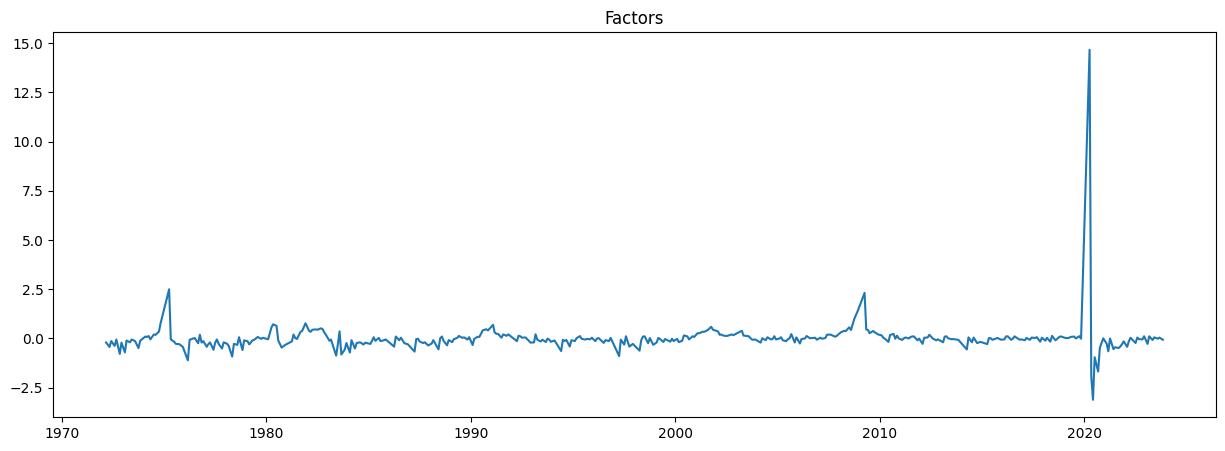

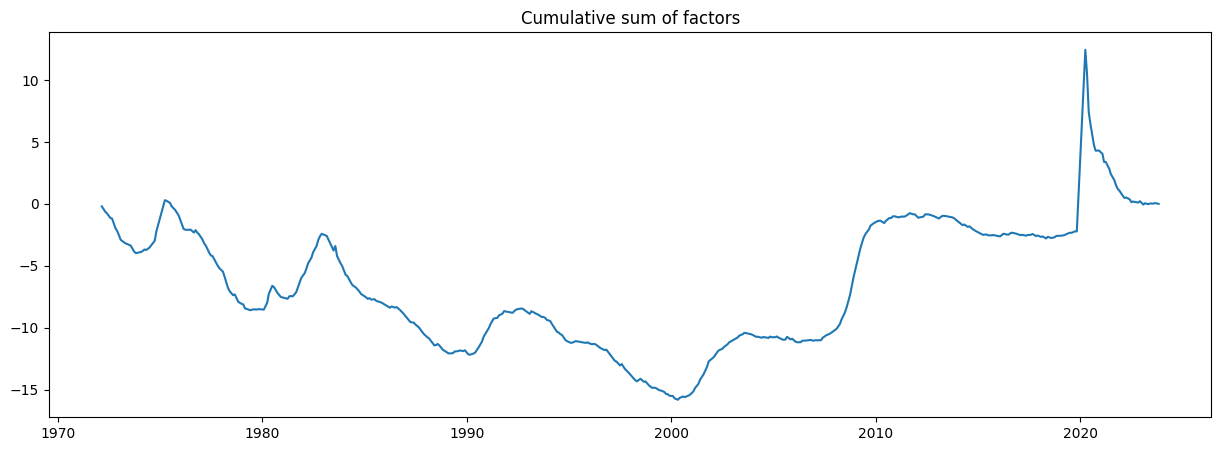

In [46]:
plt.figure(figsize=(15,5))
for i in range(res2.factors['filtered'].shape[0]):
    plt.plot(df4.index, res2.factors['filtered'][i])
plt.title('Factors')
plt.show()

plt.figure(figsize=(15,5))
for i in range(res2.factors['filtered'].shape[0]):
    plt.plot(df4.index, np.cumsum(res2.factors['filtered'][i]))
plt.title('Cumulative sum of factors')
plt.show()

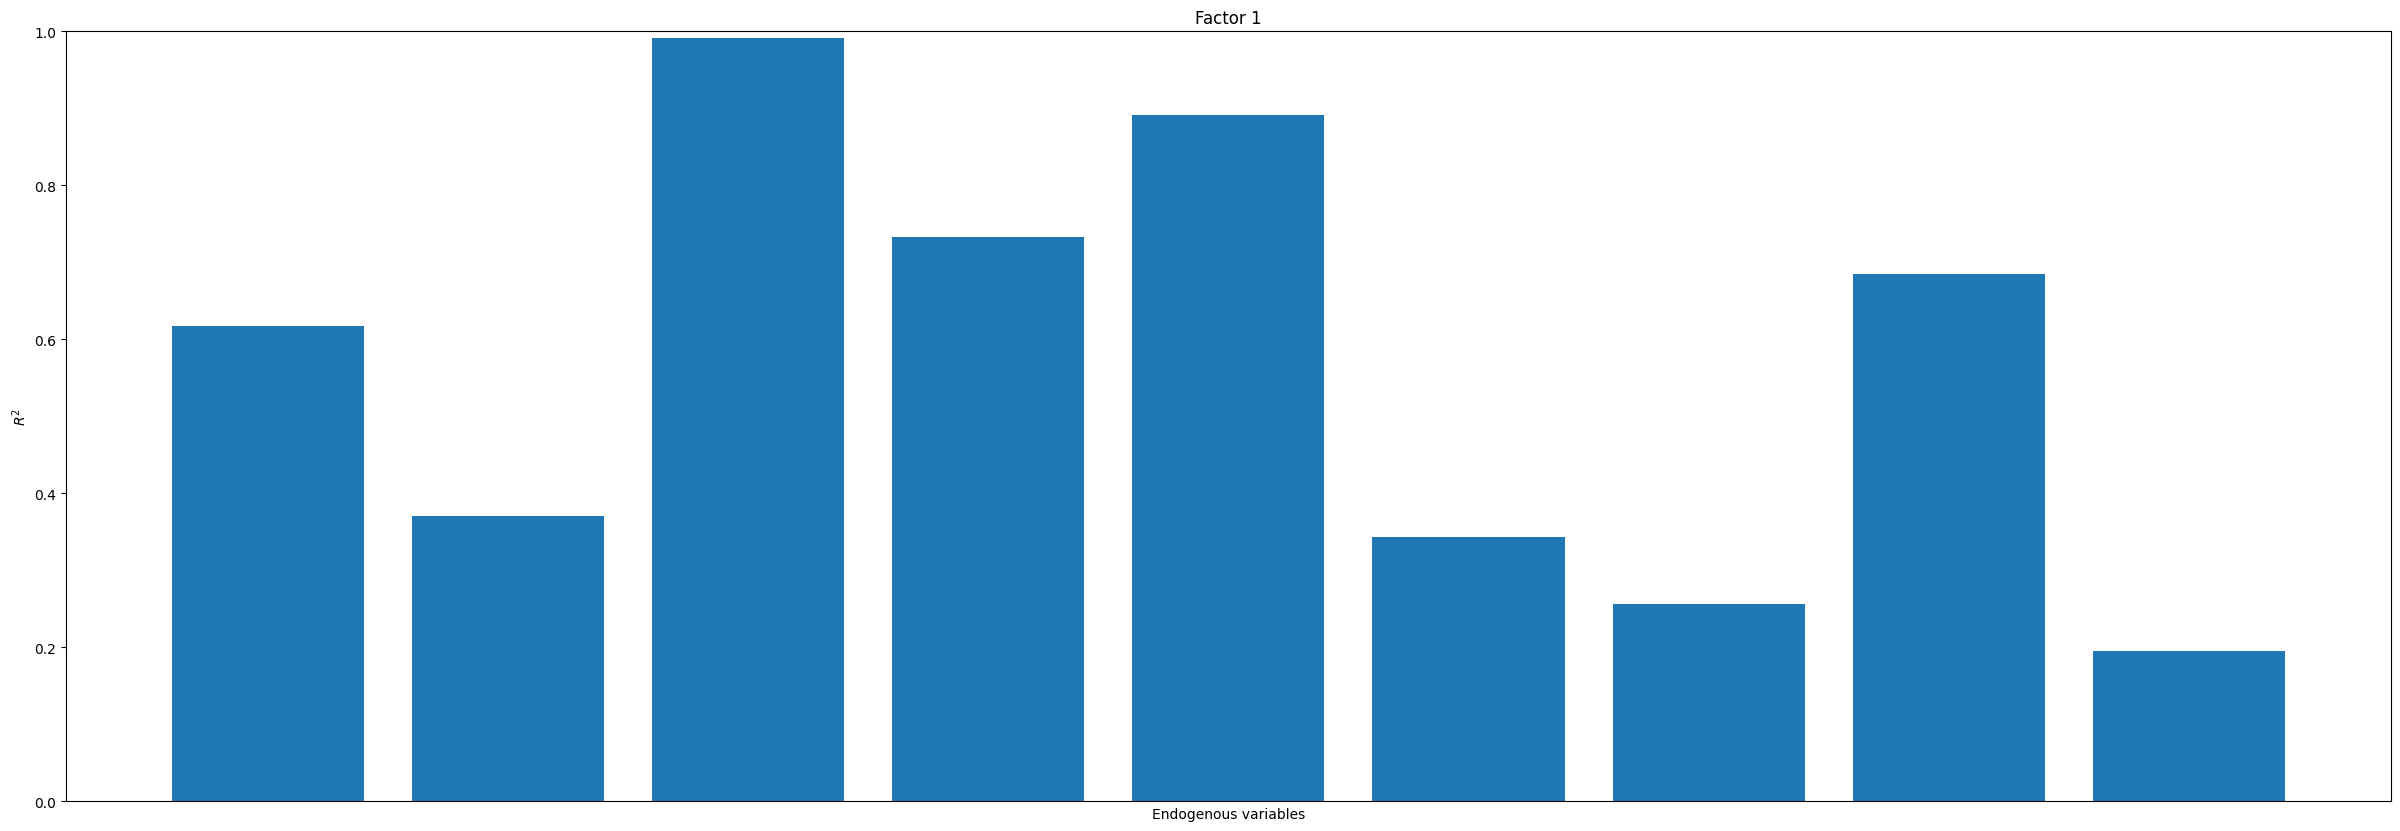

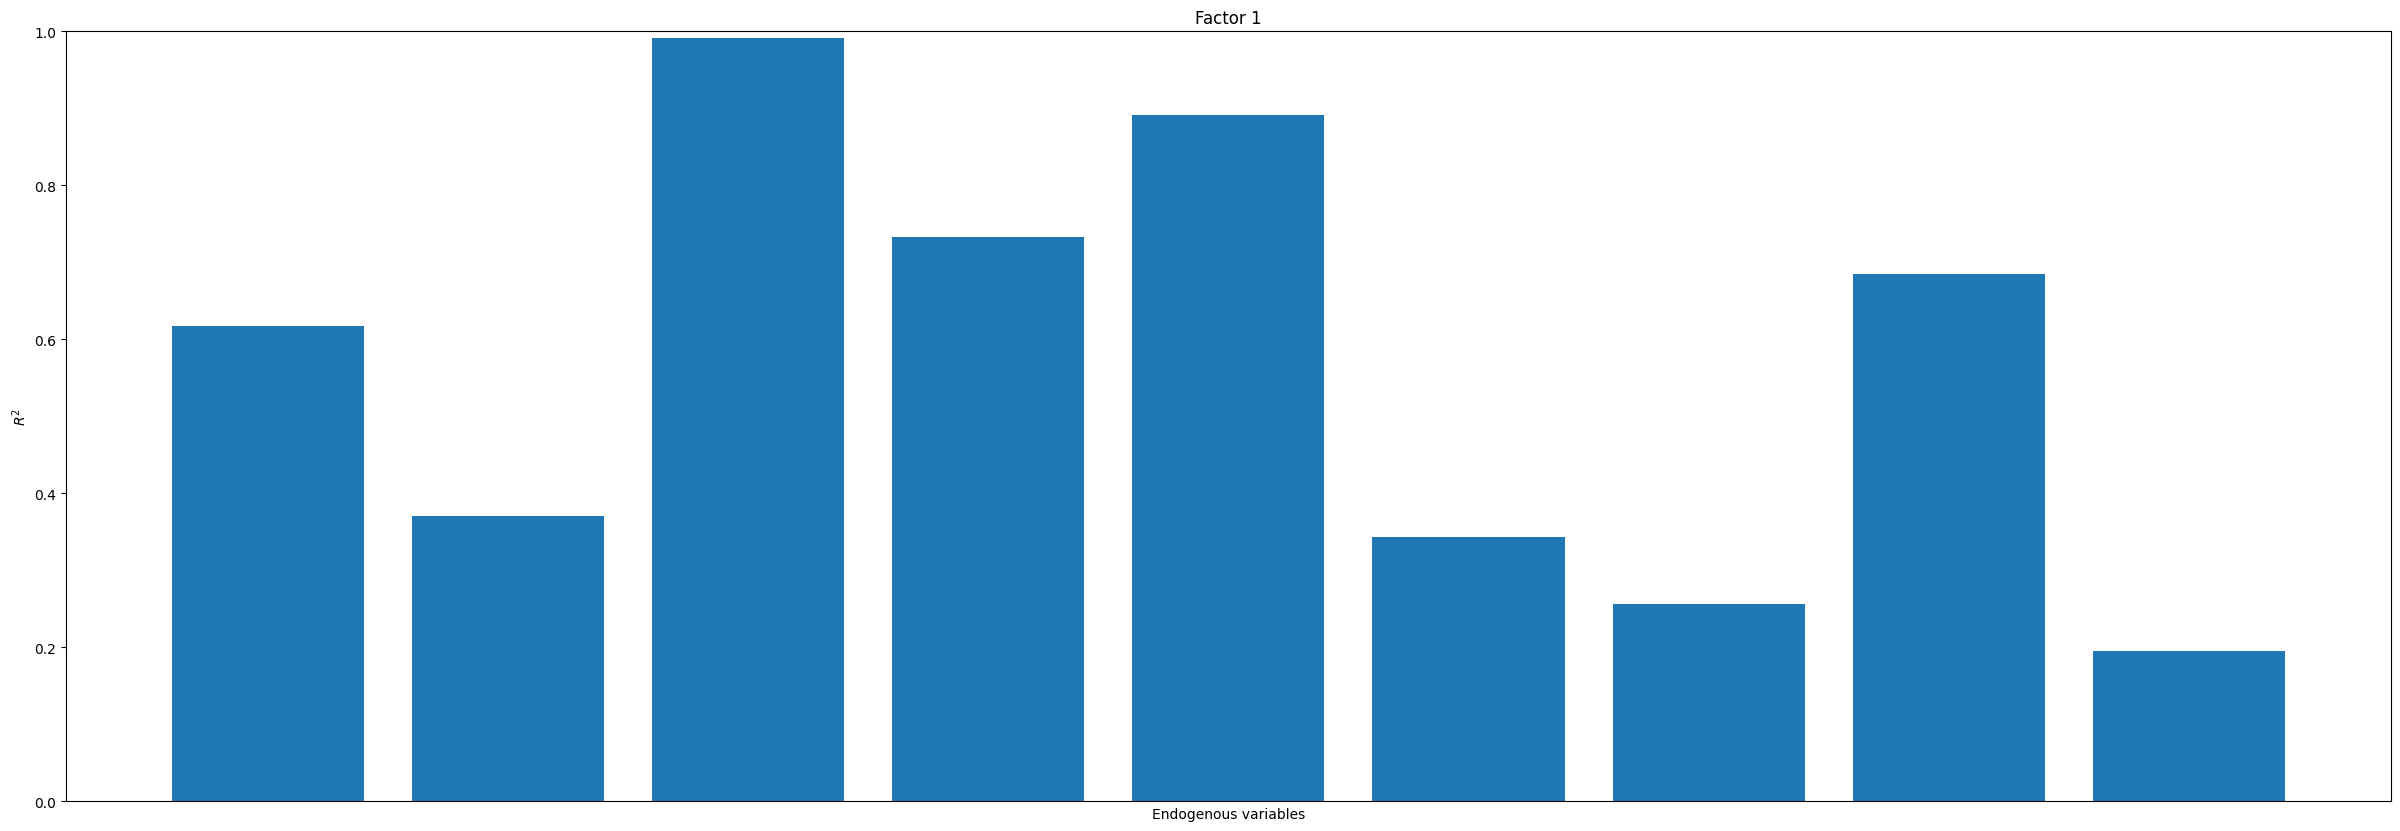

In [47]:
res2.plot_coefficients_of_determination(figsize=(30,10))